Visualize EV results - average of 40 runs, time since wind change

## load data
based on JH_model_fitting.py

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm
import os
import sys
import numpy as np
# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import tamagotchi.eval.log_analysis as log_analysis
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, drop_close_to_trial_init=False, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
        # drop_close_to_trial_init: plot_tidx marking is invalid if the wind change time is too close to the trial init, -40 plot_tidx could mean 0.8s from the last wind change
            # this option checks the lowest bound of the plot_tidx, if its corresponding time is less than 1s, drop the whole window
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for i, wind_changed_idx in enumerate(idx_where_wind_changed):
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # check if the time elasped at the lower bound is too close to trial init
            if ep_df['time'].loc[lower_bound] < 1:
                if drop_close_to_trial_init:
                    continue
            # check if time_since_last_wind_change is 0 at the lower bound
            if ep_df['time_since_last_wind_change'].loc[lower_bound] < 1:
                # print(f"wind_changed_idx {wind_changed_idx},  {ep_df['time_since_last_wind_change'].loc[lower_bound]}, lower_bound {lower_bound}, {wind_changed_idx - lower_bound}")
                continue
            # check if between lower_bound and wind_changed_idx, time_since_last_wind_change is not 0
            if 0 in ep_df['time_since_last_wind_change'].loc[lower_bound:wind_changed_idx-1].values:
                continue
            if 0 in ep_df['time_since_last_wind_change'].loc[wind_changed_idx+1:upper_bound].values:
                continue
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df


def count_consecutive_with_tolerance(group, column, tolerance=2):
    """
    Counts consecutive 1s in a column, treating gaps of 0s up to a specified tolerance as 1s.
    Fills in the counter value for the tolerated gaps.

    Parameters:
        group (pd.DataFrame): A group of the DataFrame (for a specific ep_idx).
        column (str): The column name to process.
        tolerance (int): The maximum number of consecutive 0s to treat as 1s. Default is 2.

    Returns:
        pd.Series: A Series of consecutive counts for the group, with values filled in for tolerated gaps.
    """
    # Initialize variables
    consecutive_count = 0
    i = 0
    n = len(group)
    consecutive_counts = [0] * n  # Initialize a list to store the results

    # Loop through the group
    while i < n:
        if group.iloc[i][column] == 1:
            consecutive_count += 1
            consecutive_counts[i] = consecutive_count
            i += 1
        else:
            # Check if the next `tolerance` steps contain a 1
            gap_indices = []
            for j in range(1, tolerance + 1):
                if i + j < n and group.iloc[i + j][column] == 1:
                    # Fill in the counter for the gap and the next 1
                    for k in range(i, i + j + 1):
                        consecutive_count += 1
                        consecutive_counts[k] = consecutive_count
                    i += j + 1
                    break
                gap_indices.append(i + j)
            else:
                # Reset the counter if the gap exceeds the tolerance
                consecutive_count = 0
                consecutive_counts[i] = 0
                i += 1

    return pd.Series(consecutive_counts, index=group.index)


In [ ]:
outdir = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/timing_by_quantile/'
# poisson_agents = ['plume_30011_9beecb563ff6757746898c0b75f0d7e7/poisson_noisy3x5b5.pkl',
poisson_agents = [
'plume_21943_e03b9588604c41ee7292e64a5274bfc0/poisson_noisy3x5b5.pkl']
poisson_agents = [
'plume_21943_e03b9588604c41ee7292e64a5274bfc0/poisson_noisy3x5b5.pkl',
'plume_24835_5216f9b29f4bc2d9496619e9d2132553/poisson_noisy3x5b5.pkl',
'plume_11848_abc2d820be42ae13fbdd73e28e3a04a4/poisson_noisy3x5b5.pkl']
poisson_agent_folder = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval'
tmp = []
for agent in poisson_agents:
    agent = os.path.join(poisson_agent_folder, agent)
    tmp.append(agent)
poisson_agents = tmp

for eval_pkl in poisson_agents:
    obs_pkl = eval_pkl.replace(".pkl", "_observability_test.pkl")
    eval_folder = os.path.dirname(eval_pkl) + '/'
    dataset = os.path.basename(eval_pkl).replace('.pkl', '')

    model_name = os.path.basename(os.path.dirname(eval_folder)).split('_')[1]
    print(f"now visualizing {model_name}, {dataset}")
    # check if obs file exists
    if not os.path.exists(obs_pkl):
        print(f"Observability file {obs_pkl} not found")

    # with open(obs_pkls[0], 'rb') as f_handle:
    with open(obs_pkl, 'rb') as f_handle:
        observability_tupl = pickle.load(f_handle)
        print(f"Found {len(observability_tupl)} trials in observability results")
    # with open(eval_pkls[0], 'rb') as f_handle:
    with open(eval_pkl, 'rb') as f_handle:
        # based on open_loop_perturbation.py
        selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                                n_episodes_home=960,
                                                # n_episodes_home=240,
                                                n_episodes_other=960,  
                                                balanced=False,
                                                oob_only=False,
                                                verbose=True)

        traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                    obtain_neural_activity = True, 
                                                                                                    obtain_traj_df = True, 
                                                                                                    get_traj_tmp = True,
                                                                                                    extended_metadata = True) # get_traj_tmp 
        print(traj_df_stacked.shape)
        print(stacked_neural_activity.shape)
    for item in observability_tupl:
        EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
        
    ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)

    # Preprocess the trajectory data
    # select episodes that have observability matrices
    eps_at = [True for ep_i in traj_df_stacked['ep_idx'] ]
    subset_traj_df_stacked = traj_df_stacked[eps_at]
    subset_stacked_neural_activity = stacked_neural_activity[eps_at]

    # for every episode, drop the last row
    subset_traj_df_stacked.reset_index(drop=True, inplace=True)
    last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
    print('dropping', len(last_rows), 'rows, which are the last rows of each episode') # drop because there's no terminal+1 state
    # drop the last row of each episode
    filtered_df = subset_traj_df_stacked.drop(index=last_rows)
    filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

    # calculate time since last wind change
        # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
    filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

    # # create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
    filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
    filtered_df['time'] = filtered_df['time'].round(2)
    filtered_df['turn'] = (filtered_df['turn'] * 2) - 1 # center the turn values at 0 (from 0~1 to -1~1)

    # first derivative of actions based on obs_df calculations 
    filtered_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
    filtered_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
    filtered_df['angular_velocity'] = filtered_df.groupby('ep_idx')['heading_phi_unwrap'].diff() # just once step difference, not divided by dt
    filtered_df['angular_acceleration'] = filtered_df.groupby('ep_idx')['angular_velocity'].diff()
    filtered_df['turn_dt'] = filtered_df['angular_acceleration'] / (6 * np.pi * 0.04) # given angular acceleration, calculate turn_dt, i.e. chaneg in turn action 
    # deviates from /src/tools/pybounds/examples/observability_visualize.ipynb - there look at turn_dt as abs but not step_dt by default
    filtered_df['turn_dt_abs'] = filtered_df['turn_dt'].abs() 
    filtered_df['step_dt'] = filtered_df.groupby('ep_idx')['step'].diff()
    filtered_df['step_dt_abs'] = filtered_df['step_dt'].abs()

    # drop rows with NaN
    # filtered_df.dropna(inplace=True)
    # Apply the function to each group of ep_idx
    filtered_df['odor_enc_duration'] = filtered_df.groupby('ep_idx').apply(
        lambda x: count_consecutive_with_tolerance(x, 'odor_01', tolerance=2)
    ).reset_index(level=0, drop=True)

    filtered_df['odor_enc_duration'] = filtered_df['odor_enc_duration']*0.04 # convert to seconds

    print("filtered_df shape", filtered_df.shape)
    print("filtered_neural_activity shape", filtered_neural_activity.shape)

    # Preprocess the EV data 
    # stack the EV data
    ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
    EV_no_nan = pd.concat(ls_EV_no_nan)
    print(EV_no_nan.shape)
    # Merge with filtered_dfa
    EV_no_nan['time'] = EV_no_nan['time'].round(2)
    EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 
                                            'odor_lastenc', 'odor_01', 'step', 'turn', 'step_dt', 'turn_dt', 'step_dt_abs', 'turn_dt_abs',
                                            'loc_x', 'loc_y', 'wind_angle_ground_theta']], on=['ep_idx', 'time'], how='inner')


    EV_no_nan_shifted = EV_no_nan.copy()
    window_length = 10
    if 'w6' in obs_pkl:
        window_length = 6
    print(f"Using window length {window_length}")


    EV_no_nan_shifted['zeta_shifted'] = EV_no_nan_shifted.groupby('ep_idx')['zeta'].shift(int(window_length/2))
    EV_no_nan_shifted['zeta_shifted_qcut'] = EV_no_nan_shifted['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan_shifted['zeta_shifted_qcut_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    # drop the first 10 idx in each episode
    EV_no_nan_shifted = EV_no_nan_shifted.groupby('ep_idx').apply(lambda x: x.iloc[window_length:])
    EV_no_nan_shifted = EV_no_nan_shifted.droplevel(0)



    # EV_no_nan_around = tidx_around_wind_change(EV_no_nan, around_range=10, drop_incomplete=False, drop_close_to_trial_init=True, verbose=True)

    # find the quantile of step_dt and turn_dt for each episode
    # EV_no_nan_around['step_dt_quantile_per_eps'] = EV_no_nan_around.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    # EV_no_nan_around['turn_dt_quantile_per_eps'] = EV_no_nan_around.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    # EV_no_nan_around['step_dt_abs_quantile_per_eps'] = EV_no_nan_around.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))
    # EV_no_nan_around['turn_dt_abs_quantile_per_eps'] = EV_no_nan_around.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))

    EV_no_nan['step_dt_quantile_per_eps'] = EV_no_nan.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan['turn_dt_quantile_per_eps'] = EV_no_nan.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan['step_dt_abs_quantile_per_eps'] = EV_no_nan.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))
    EV_no_nan['turn_dt_abs_quantile_per_eps'] = EV_no_nan.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))

    EV_no_nan_shifted['step_dt_quantile_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan_shifted['turn_dt_quantile_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    EV_no_nan_shifted['step_dt_abs_quantile_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))
    EV_no_nan_shifted['turn_dt_abs_quantile_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))

    filtered_df['step_dt_quantile_per_eps'] = filtered_df.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    filtered_df['turn_dt_quantile_per_eps'] = filtered_df.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x, q=10, labels=False))
    filtered_df['step_dt_abs_quantile_per_eps'] = filtered_df.groupby('ep_idx')['step_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))
    filtered_df['turn_dt_abs_quantile_per_eps'] = filtered_df.groupby('ep_idx')['turn_dt'].transform(lambda x: pd.qcut(x.abs(), q=10, labels=False))

    cols_to_plot = ['step_dt_abs_quantile_per_eps', 'turn_dt_abs_quantile_per_eps']
    dfs = [filtered_df]
    # dfs = [EV_no_nan, EV_no_nan_shifted, filtered_df]
    df_titles = [False]
    # df_titles = ['Original', 'Shifted', False]
    for df_i, df in enumerate(dfs):
        # Sort quantiles
        for col_i, plot_by in enumerate(cols_to_plot):
            df = df.dropna(subset=[plot_by])
            quantiles = df[plot_by].unique()
            quantiles.sort()
            print(f"Quantiles for {plot_by}: {quantiles}")

            df_title = df_titles[df_i]

            # Set up plot
            fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

            # Generate distinct colors using a colormap
            cmap = cm.get_cmap('viridis', len(quantiles))  # 'viridis' ensures good contrast
            print(f"df.shape {df.shape}")
            # Iterate over quantiles and plot density
            for i, now_qt in enumerate(quantiles):
                print(f"now_qt {now_qt}")
        
                tmp_df = df[df[plot_by] == now_qt]
                print(f"tmp_df shape {tmp_df.shape}")        
                if len(tmp_df) > 1:
                    kde = gaussian_kde(tmp_df['time_since_last_wind_change'])
                    x_vals = np.linspace(tmp_df['time_since_last_wind_change'].min(), 
                                        tmp_df['time_since_last_wind_change'].max(), 100)
                    # integrate the density to get the probability
                    kde_vals = kde(x_vals)
                    # Compute integral using Trapezoidal Rule
                    integral_trapz = np.trapz(kde_vals, x_vals)
                    print(f"Integral using Trapezoidal Rule: {integral_trapz:.4f}")
                    ax.plot(x_vals, kde(x_vals), color=cmap(i), label=f'{int(now_qt*10)}-{int((now_qt+1)*10)}th Percentile')

            if plot_by == 'step_dt_abs_quantile_per_eps':
                if df_title:
                    title = f"Absolute Acceleration Deciles, {df_title}"
                else:
                    title = f"Absolute Acceleration Deciles"
            elif plot_by == 'turn_dt_abs_quantile_per_eps':
                if df_title:
                    title = f"Absolute Angular Acceleration Deciles, {df_title}"
                else:
                    title = f"Absolute Angular Acceleration Deciles"
            # Add legend and labelss
            ax.set_xlabel("Time Since Wind Change (s)", fontdict={'size': 20})
            ax.set_ylabel("Probability Density", fontdict={'size': 20})
            ax.set_title(title, fontdict={'size': 20})
            # ax.legend(loc='best', fontsize=8, frameon=False)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.locator_params(nbins=7)
            # add back bottom and left
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0)
            ax.spines['right'].set_linewidth(0)
            
            # adjust white space (left = 0, right = 1, top = 1, bottom = 0) move the start and end of the plot 0~1
            fig.subplots_adjust(left=0.2, right=0.9, top=0.93, bottom=0.15)
            
            if not df_title:
                fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_all_trials.png")
            else:
                fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_{df_title}.png")
            
    for df_i, df in enumerate(dfs):
        # Sort quantiles
        for col_i, plot_by in enumerate(cols_to_plot):
            df = df.dropna(subset=[plot_by])
            quantiles = df[plot_by].unique()
            quantiles.sort()
            print(f"Quantiles for {plot_by}: {quantiles}")

            df_title = df_titles[df_i]

            # Set up plot
            fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

            # Generate distinct colors using a colormap
            cmap = cm.get_cmap('viridis', len(quantiles))  # 'viridis' ensures good contrast
            print(f"df.shape {df.shape}")
            # Iterate over quantiles and plot density
            for i, now_qt in enumerate(quantiles):
                tmp_df = df[df[plot_by] == now_qt]
                tmp_df = tmp_df[tmp_df['odor_enc_duration'] > 0]
                if len(tmp_df) > 1:
                    kde = gaussian_kde(tmp_df['odor_enc_duration'])
                    x_vals = np.linspace(tmp_df['odor_enc_duration'].min(), 
                                        tmp_df['odor_enc_duration'].max(), 100)
                    # integrate the density to get the probability
                    kde_vals = kde(x_vals)
                    # Compute integral using Trapezoidal Rule
                    integral_trapz = np.trapz(kde_vals, x_vals)
                    print(f"Integral using Trapezoidal Rule: {integral_trapz:.4f}")
                    ax.plot(x_vals, kde(x_vals), color=cmap(i), label=f'{int(now_qt*10)}-{int((now_qt+1)*10)}th Percentile')

            if plot_by == 'step_dt_abs_quantile_per_eps':
                if df_title:
                    title = f"Absolute Acceleration, {df_title}"
                else:
                    title = f"Absolute Acceleration"
            elif plot_by == 'turn_dt_abs_quantile_per_eps':
                if df_title:
                    title = f"Absolute Angular Acceleration, {df_title}"
                else:
                    title = f"Absolute Angular Acceleration"
            # Add legend and labelss
            ax.set_xlabel("Odor Contact Duration (s)", fontdict={'size': 20})
            ax.set_ylabel("Probability Density", fontdict={'size': 20})
            ax.set_title(title, fontdict={'size': 20})
            # ax.legend(loc='best', fontsize=8, frameon=False)
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.locator_params(nbins=10)
            # add back bottom and left
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0)
            ax.spines['right'].set_linewidth(0)
            
            fig.subplots_adjust(left=0.2, right=0.9, top=0.93, bottom=0.15)
            if not df_title:
                fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_all_trials_odor.png")
            else:
                fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_{df_title}_odor.png")

now visualizing 21943, poisson_noisy3x5b5
Found 196 trials in observability results


Quantiles for step_dt_abs_quantile_per_eps: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
df.shape (200053, 104)
now_qt 0.0
tmp_df shape (20402, 104)
Integral using Trapezoidal Rule: 0.9721
now_qt 1.0
tmp_df shape (20024, 104)
Integral using Trapezoidal Rule: 0.9727
now_qt 2.0
tmp_df shape (19757, 104)
Integral using Trapezoidal Rule: 0.9703
now_qt 3.0
tmp_df shape (20038, 104)
Integral using Trapezoidal Rule: 0.9692
now_qt 4.0
tmp_df shape (20098, 104)
Integral using Trapezoidal Rule: 0.9670
now_qt 5.0
tmp_df shape (19669, 104)
Integral using Trapezoidal Rule: 0.9672
now_qt 6.0
tmp_df shape (19953, 104)
Integral using Trapezoidal Rule: 0.9640
now_qt 7.0
tmp_df shape (19842, 104)
Integral using Trapezoidal Rule: 0.9613
now_qt 8.0
tmp_df shape (19947, 104)
Integral using Trapezoidal Rule: 0.9585
now_qt 9.0
tmp_df shape (20323, 104)
Integral using Trapezoidal Rule: 0.9321
Quantiles for turn_dt_abs_quantile_per_eps: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
df.shape (199093, 104)
now_qt 0.0
tmp_df shape (20323, 

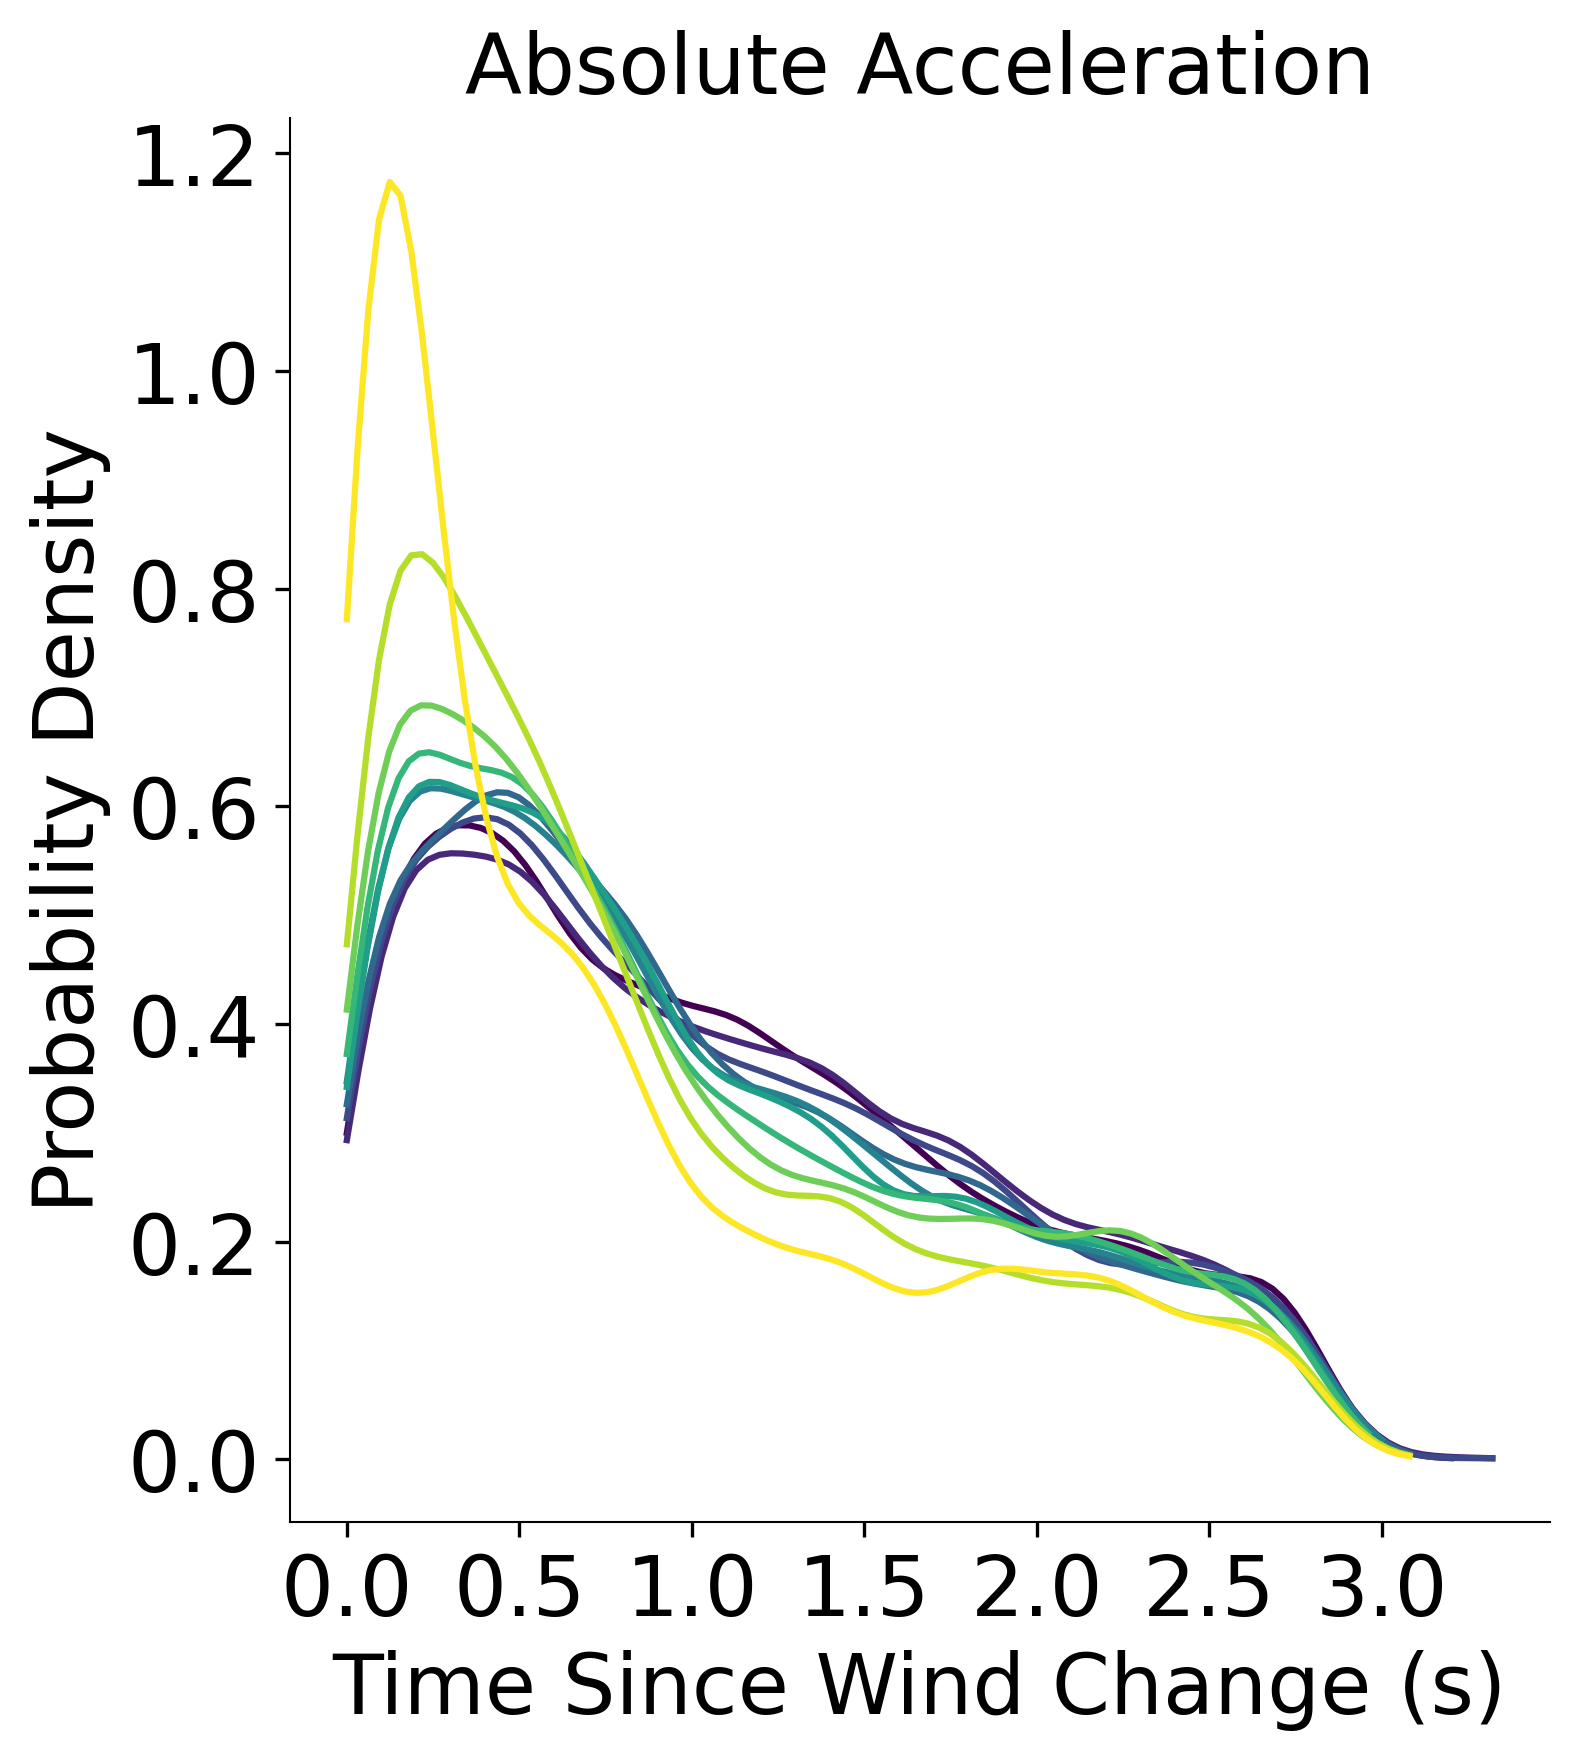

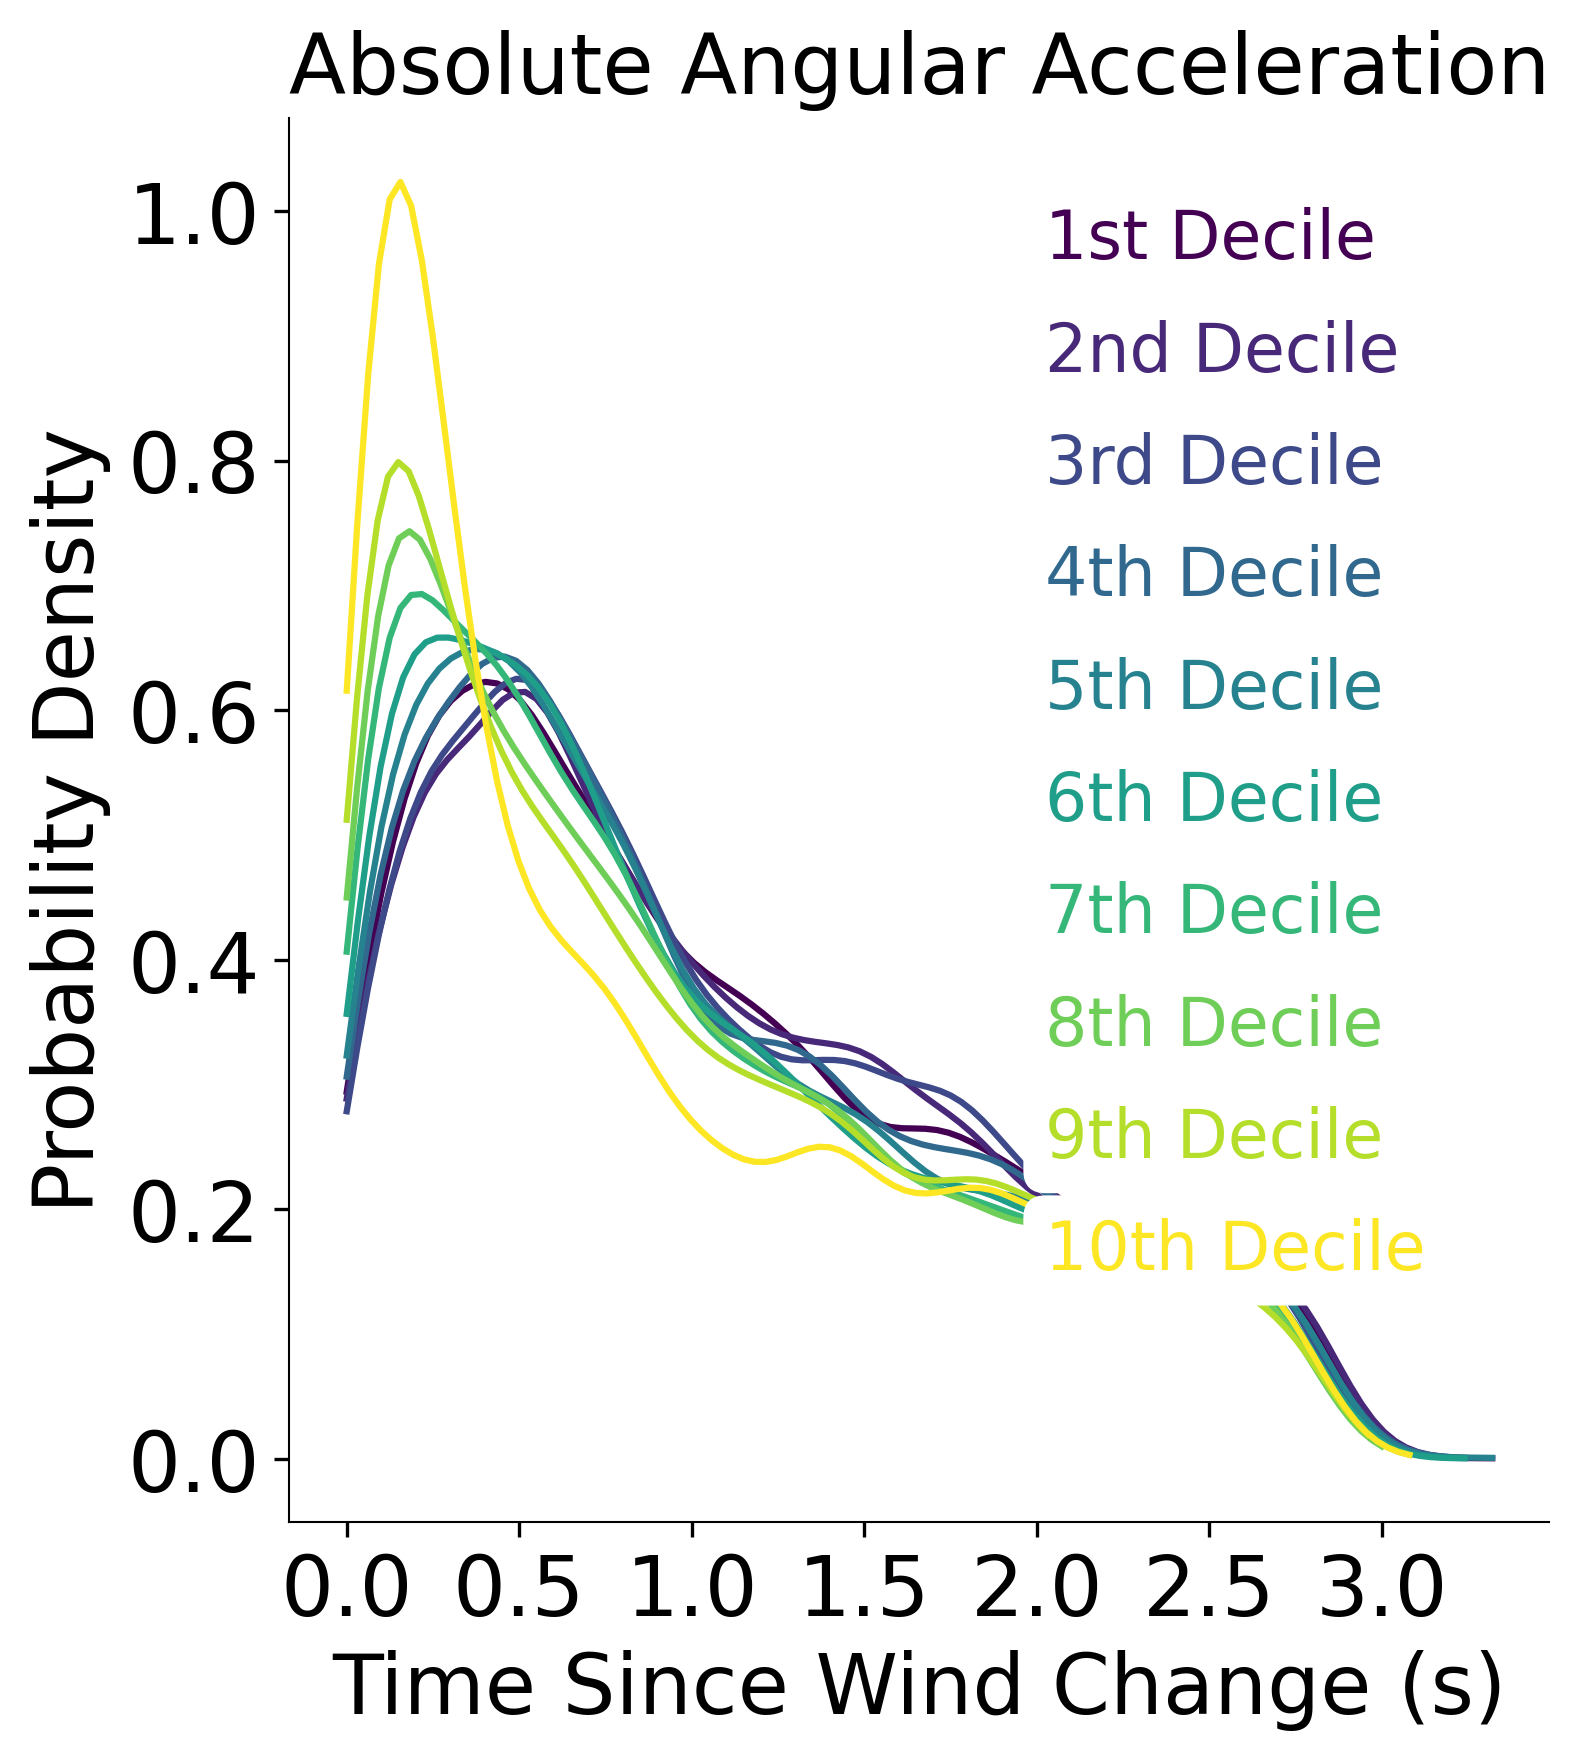

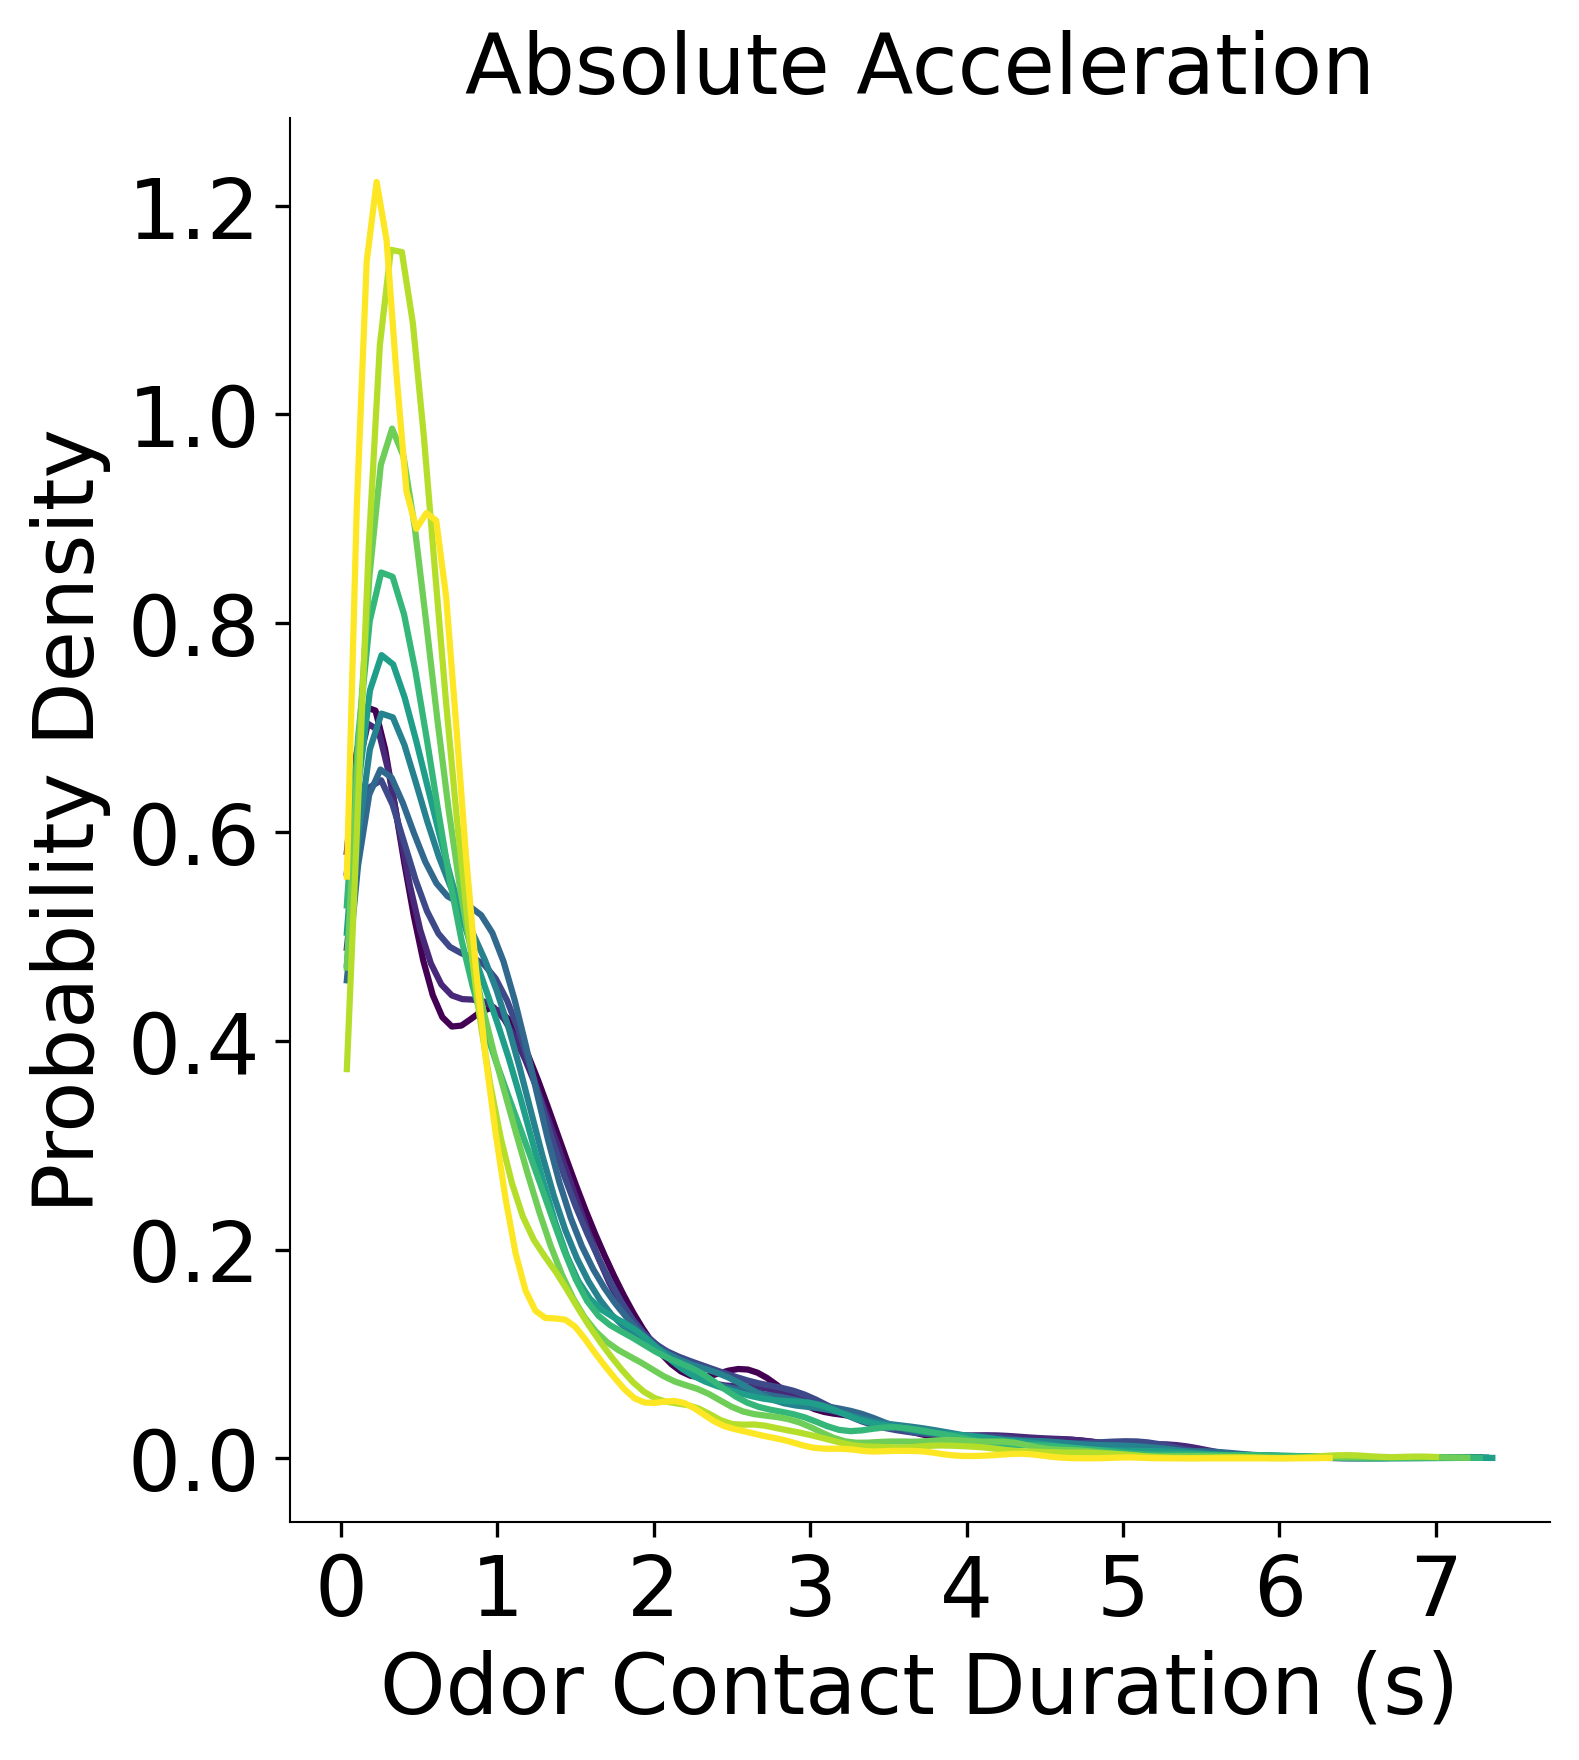

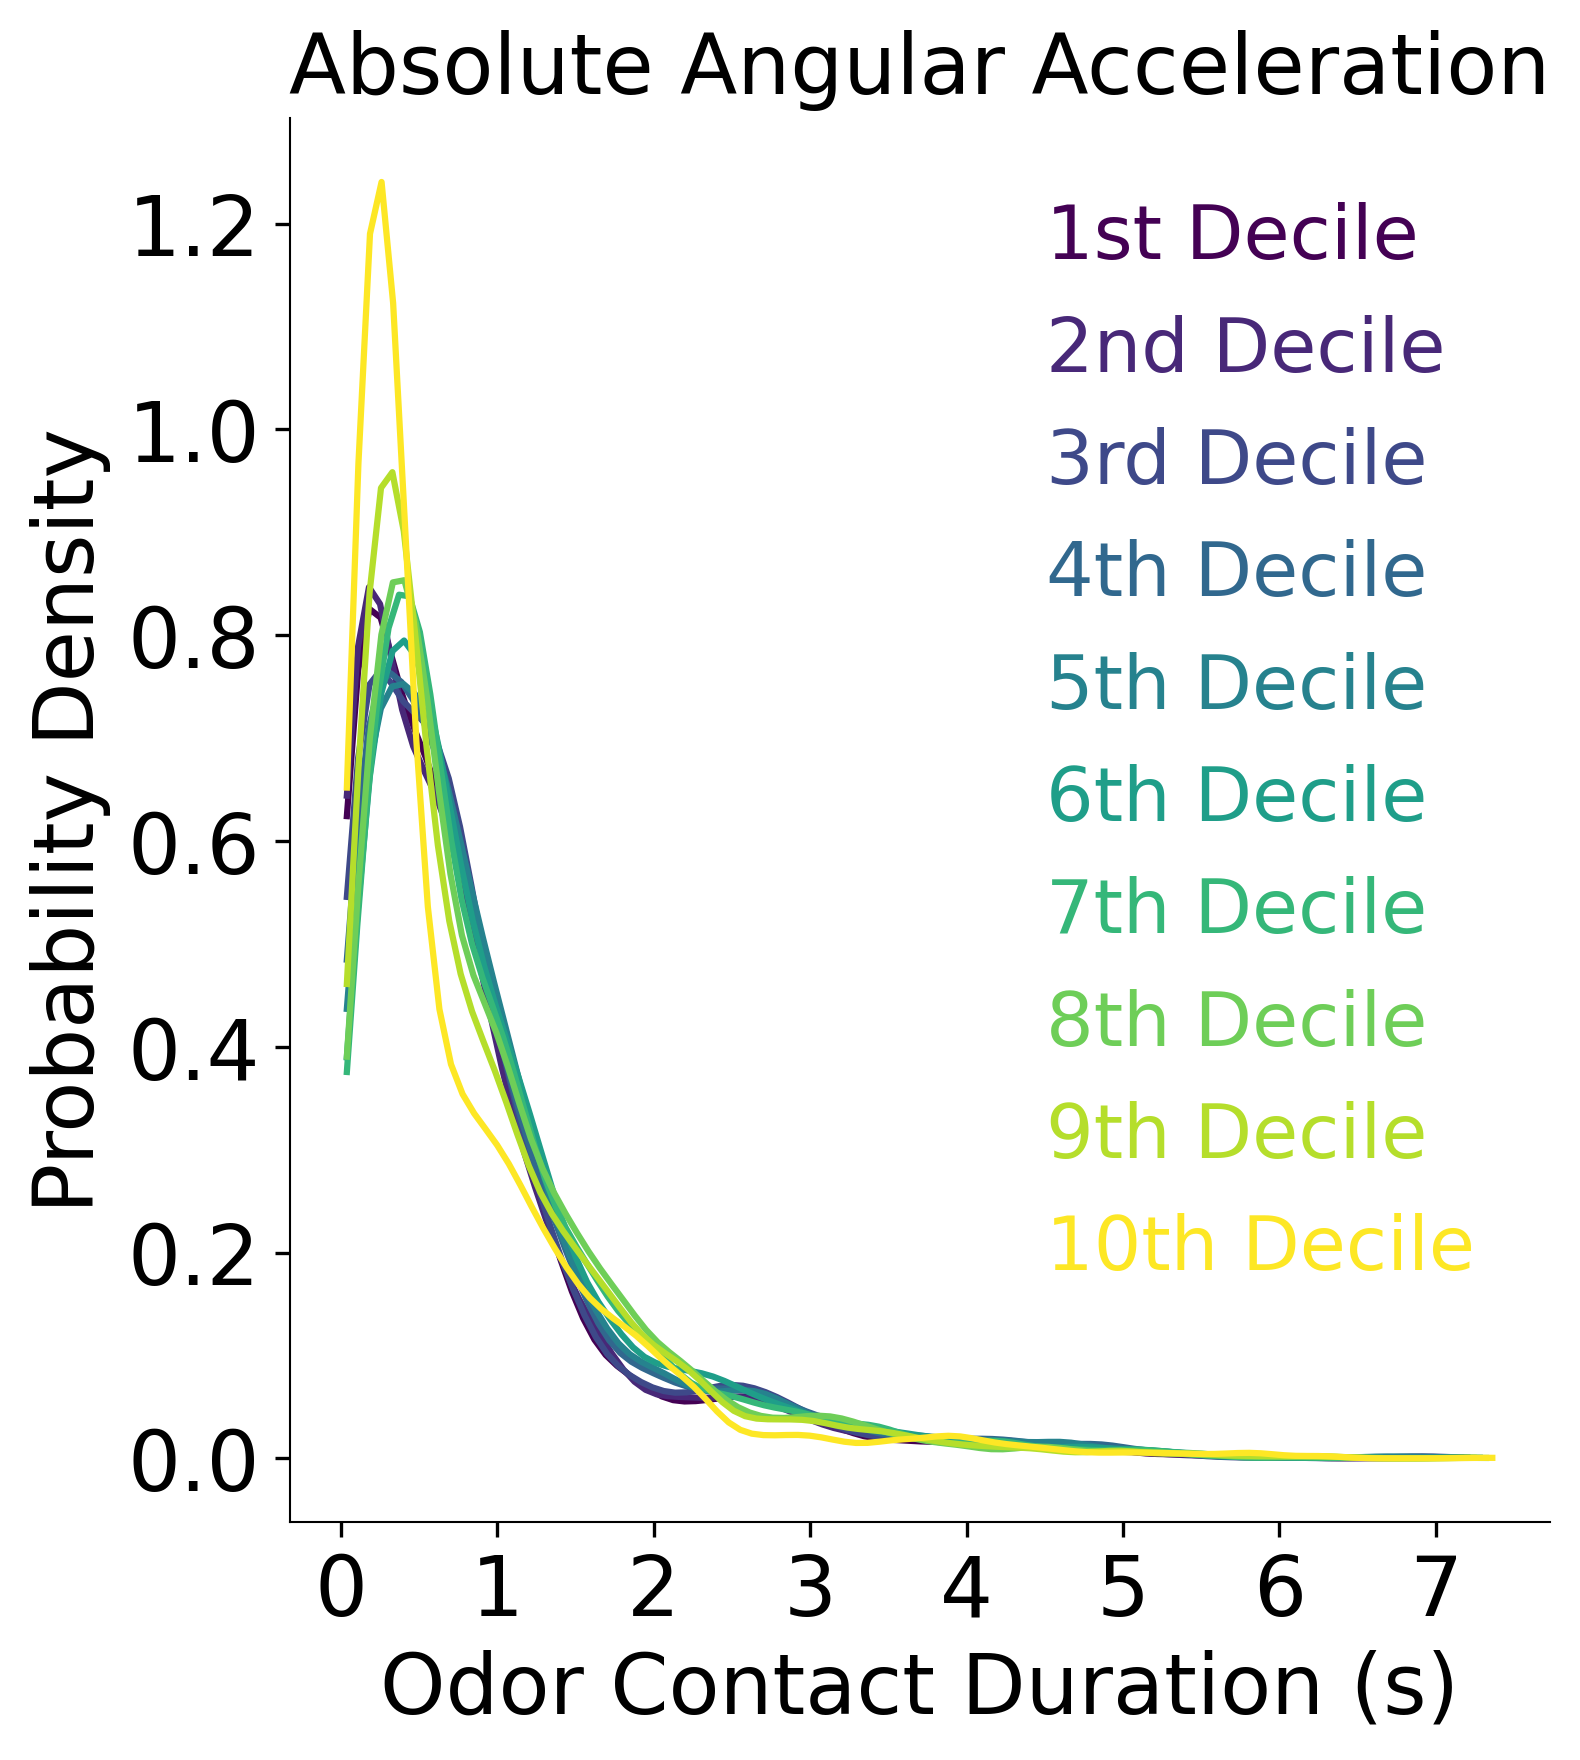

In [ ]:
for df_i, df in enumerate(dfs):
    # Sort quantiles
    for col_i, plot_by in enumerate(cols_to_plot):
        df = df.dropna(subset=[plot_by])
        quantiles = df[plot_by].unique()
        quantiles.sort()
        print(f"Quantiles for {plot_by}: {quantiles}")

        df_title = df_titles[df_i]

        # Set up plot
        fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

        # Generate distinct colors using a colormap
        cmap = cm.get_cmap('viridis', len(quantiles))  # 'viridis' ensures good contrast
        print(f"df.shape {df.shape}")
        # Iterate over quantiles and plot density
        for i, now_qt in enumerate(quantiles):
            print(f"now_qt {now_qt}")
    
            tmp_df = df[df[plot_by] == now_qt]
            print(f"tmp_df shape {tmp_df.shape}")        
            if len(tmp_df) > 1:
                kde = gaussian_kde(tmp_df['time_since_last_wind_change'])
                x_vals = np.linspace(tmp_df['time_since_last_wind_change'].min(), 
                                    tmp_df['time_since_last_wind_change'].max(), 100)
                # integrate the density to get the probability
                kde_vals = kde(x_vals)
                # Compute integral using Trapezoidal Rule
                integral_trapz = np.trapz(kde_vals, x_vals)
                print(f"Integral using Trapezoidal Rule: {integral_trapz:.4f}")
                ax.plot(x_vals, kde(x_vals), color=cmap(i), label=f'{int(now_qt*10)}-{int((now_qt+1)*10)}th Percentile')

        if plot_by == 'step_dt_abs_quantile_per_eps':
            if df_title:
                title = f"Absolute Acceleration, {df_title}"
            else:
                title = f"Absolute Acceleration"
        elif plot_by == 'turn_dt_abs_quantile_per_eps':
            if df_title:
                title = f"Absolute Angular Acceleration, {df_title}"
            else:
                title = f"Absolute Angular Acceleration"
        # Add legend and labelss
        ax.set_xlabel("Time Since Wind Change (s)", fontdict={'size': 20})
        ax.set_ylabel("Probability Density", fontdict={'size': 20})
        ax.set_title(title, fontdict={'size': 20})
        # ax.legend(loc='best', fontsize=8, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.locator_params(nbins=10)
        # add back bottom and left
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['top'].set_linewidth(0)
        ax.spines['right'].set_linewidth(0)
        
        # if col_i:
        #     # only one fig needs to have decile labels
        #     for i, now_qt in enumerate(quantiles):
        #         if now_qt + 1 == 1:
        #             label = '1st Decile'
        #         elif now_qt + 1 == 2:
        #             label = '2nd Decile'
        #         elif now_qt + 1 == 3:
        #             label = '3rd Decile'
        #         else:
        #             label = f'{int(now_qt + 1)}th Decile'
        #         ax.text(0.6, 0.9 - (i * 0.08), label, 
        #                 color=cmap(i), transform=ax.transAxes, fontsize=16,
        #                 bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))
        fig.subplots_adjust(left=0.2, right=0.9, top=0.93, bottom=0.15)
        
        if not df_title:
            fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_all_trials.png")
        else:
            fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_{df_title}.png")
        
for df_i, df in enumerate(dfs):
    # Sort quantiles
    for col_i, plot_by in enumerate(cols_to_plot):
        df = df.dropna(subset=[plot_by])
        quantiles = df[plot_by].unique()
        quantiles.sort()
        print(f"Quantiles for {plot_by}: {quantiles}")

        df_title = df_titles[df_i]

        # Set up plot
        fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

        # Generate distinct colors using a colormap
        cmap = cm.get_cmap('viridis', len(quantiles))  # 'viridis' ensures good contrast
        print(f"df.shape {df.shape}")
        # Iterate over quantiles and plot density
        for i, now_qt in enumerate(quantiles):
            tmp_df = df[df[plot_by] == now_qt]
            tmp_df = tmp_df[tmp_df['odor_enc_duration'] > 0]
            if len(tmp_df) > 1:
                kde = gaussian_kde(tmp_df['odor_enc_duration'])
                x_vals = np.linspace(tmp_df['odor_enc_duration'].min(), 
                                    tmp_df['odor_enc_duration'].max(), 100)
                # integrate the density to get the probability
                kde_vals = kde(x_vals)
                # Compute integral using Trapezoidal Rule
                integral_trapz = np.trapz(kde_vals, x_vals)
                print(f"Integral using Trapezoidal Rule: {integral_trapz:.4f}")
                ax.plot(x_vals, kde(x_vals), color=cmap(i), label=f'{int(now_qt*10)}-{int((now_qt+1)*10)}th Percentile')

        if plot_by == 'step_dt_abs_quantile_per_eps':
            if df_title:
                title = f"Absolute Acceleration, {df_title}"
            else:
                title = f"Absolute Acceleration"
        elif plot_by == 'turn_dt_abs_quantile_per_eps':
            if df_title:
                title = f"Absolute Angular Acceleration, {df_title}"
            else:
                title = f"Absolute Angular Acceleration"
        # Add legend and labelss
        ax.set_xlabel("Odor Contact Duration (s)", fontdict={'size': 20})
        ax.set_ylabel("Probability Density", fontdict={'size': 20})
        ax.set_title(title, fontdict={'size': 20})
        # ax.legend(loc='best', fontsize=8, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.locator_params(nbins=10)
        # add back bottom and left
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['top'].set_linewidth(0)
        ax.spines['right'].set_linewidth(0)
        
        # if col_i:
        #     # only one fig needs to have decile labels
        #     for i, now_qt in enumerate(quantiles):
        #         if now_qt + 1 == 1:
        #             label = '1st Decile'
        #         elif now_qt + 1 == 2:
        #             label = '2nd Decile'
        #         elif now_qt + 1 == 3:
        #             label = '3rd Decile'
        #         else:
        #             label = f'{int(now_qt + 1)}th Decile'
                
        #         ax.text(0.6, 0.9 - (i * 0.08), label, 
        #                 color=cmap(i), transform=ax.transAxes, fontsize=18,
        #                 bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))

        fig.subplots_adjust(left=0.2, right=0.9, top=0.93, bottom=0.15)
        if not df_title:
            fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_all_trials_odor.png")
        else:
            fig.savefig(f"{outdir}/{model_name}_{dataset}_{plot_by}_{df_title}_odor.png")

saved to /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.01_train_std_pois_wind/eval/timing_by_quantile//legend.png


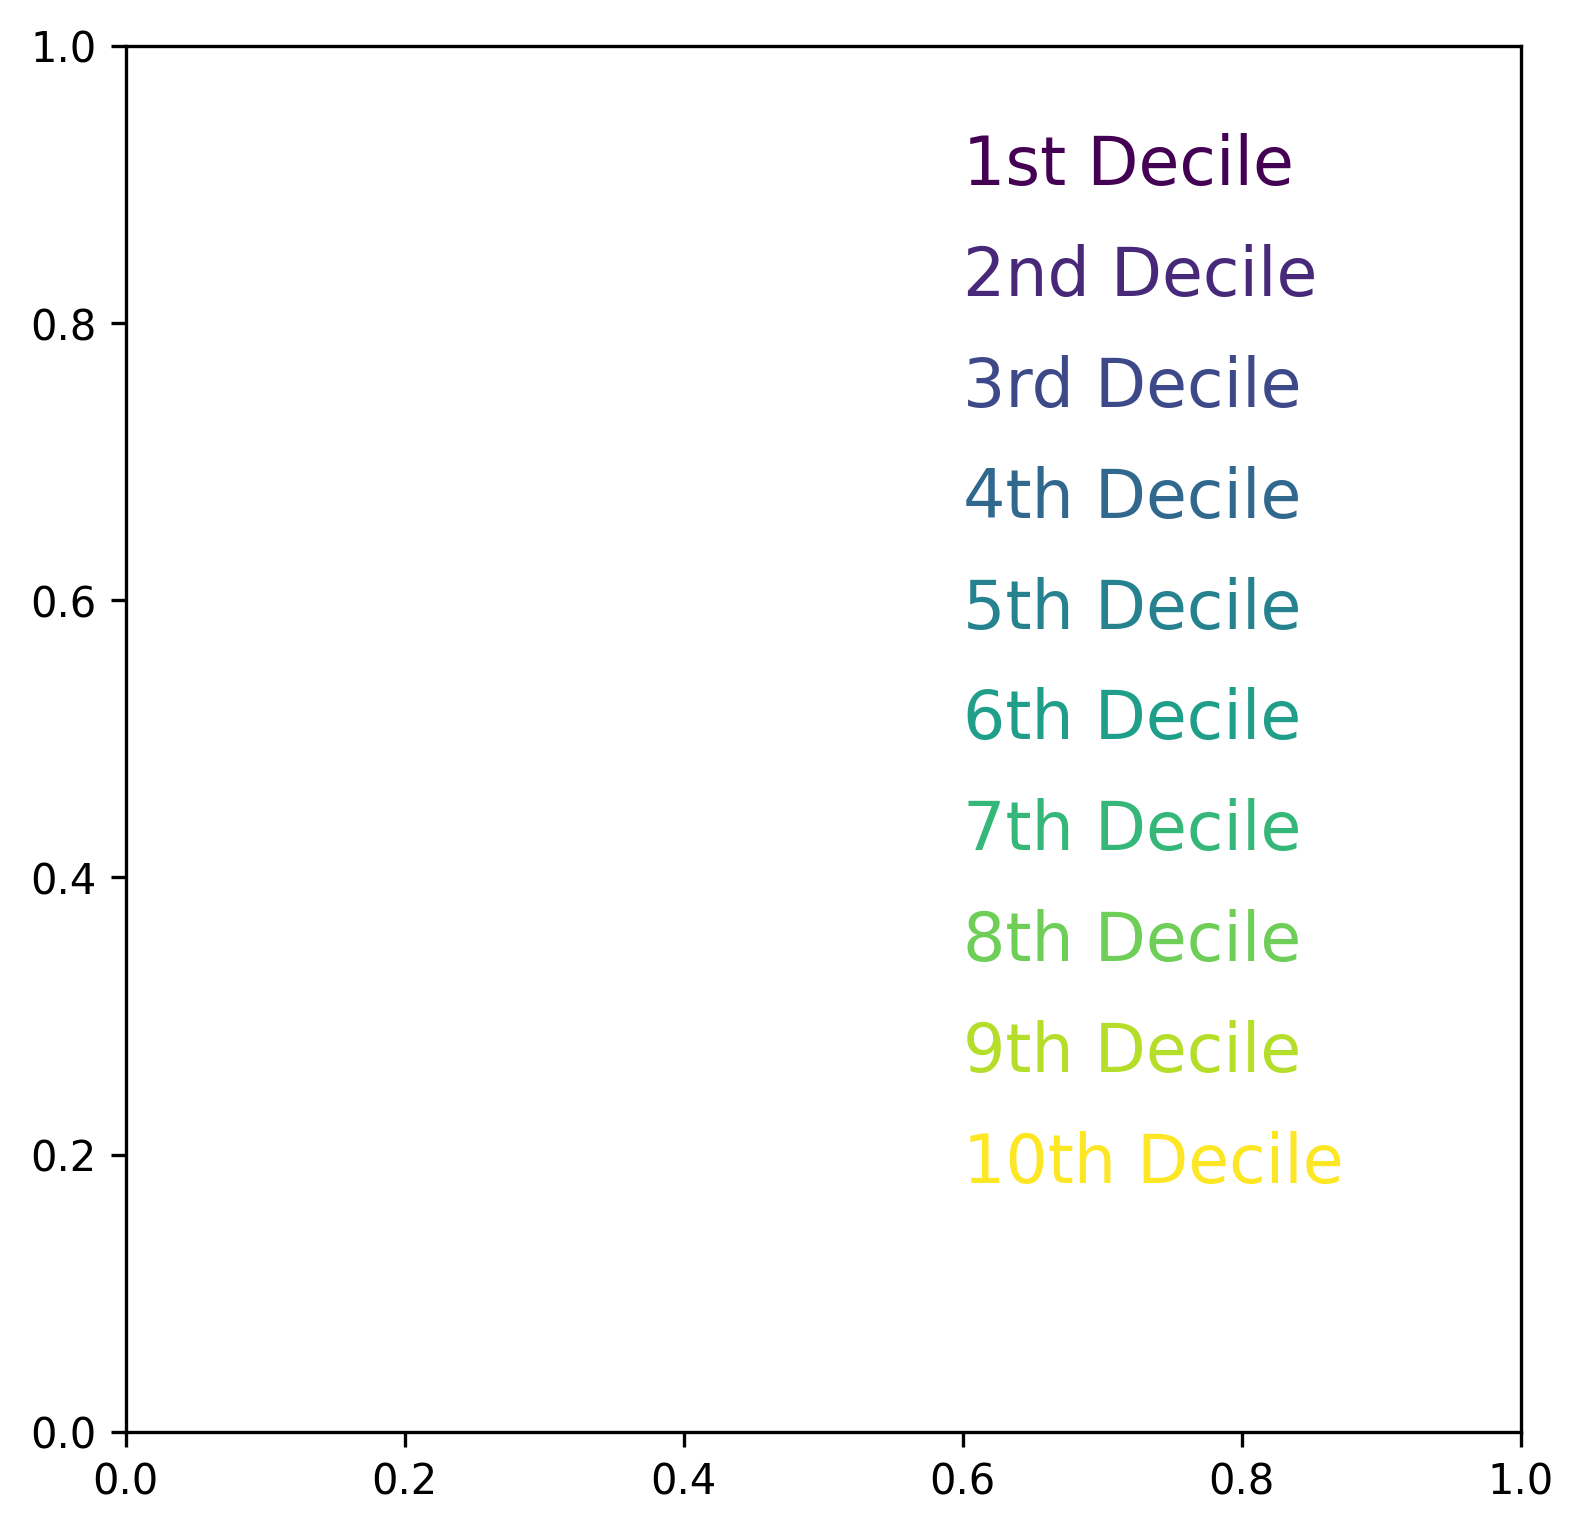

In [19]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)
for i, now_qt in enumerate(quantiles):
    if now_qt + 1 == 1:
        label = '1st Decile'
    elif now_qt + 1 == 2:
        label = '2nd Decile'
    elif now_qt + 1 == 3:
        label = '3rd Decile'
    else:
        label = f'{int(now_qt + 1)}th Decile'
    ax.text(0.6, 0.9 - (i * 0.08), label, 
            color=cmap(i), transform=ax.transAxes, fontsize=16,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.3'))
fig.savefig(f"{outdir}/legend.png")
print("saved to", f"{outdir}/legend.png")